In [1]:
!pip install iapws


You should consider upgrading via the 'pip install --upgrade pip' command.


Engy-4350: Nuclear Reactor Engineering Spring 2019 UMass Lowell; Prof. V. F. de Almeida **19Mar2019**

# 05. Two-Temperature Boiling Water Reactor Example
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\uvar}{\boldsymbol{u}}
  \newcommand{\fvar}{\boldsymbol{f}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Power}{\mathcal{P}}
$

---
## Table of Contents
* [Objectives](#obj)
* [Introduction](#intro)
* [Problem Statement](#ps)
* [Input Data](#data)
* [Steady state](#ss)
* [Vector ODE System](#vodes)
* [Function library](#flib)
* [One-Group Energy Neutron Balance](#nbal)
* [Reactivity Step with Negative Feedback Results](#res1)
* [Interactive Results](#ires)
---

## Objectives<a id="obj"></a>
+ Use one-group energy, two-temperature, point-reactor dynamics modeling (six-group delayed neutron emitters) to obtain insight on neutron density behavior with time-dependent reactivity of a Boiling Water Reactor.
+ Explore and understand intrinsic temperature reactivity coefficient feedback from nuclear sources.

## Introduction<a id="intro"></a>

In-class course notes OneNote [ChEn-4350-feedback](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/Eo9JUns42F1Pqmq4tFS9sJsBv2jF8UDQvRb5l5Z2D5ssag?e=FDeSpV).

Refer to Notebook 03.


## Problem Statement<a id="ps"></a>

Consider a high temperature gas cooled reactor, with UO$_2$ fuel and a graphite moderator.
Given the neutron generation time $\ell$, delayed neutron fraction, $\beta$, decay constants of a six-group delayed neutron emitters, $\lambda_i$, and corresponding yield of delayed neutron fractions for each emitter, $\beta_i$, calculate the pointwise neutron density variation with time for **varying** neutron reactivity, $\rho(t)$.

![](images/point-reactor-hx.png)

## Input Data<a id="data"></a>

Data pertaining to one-group energy neutron balance. 

Name                        | Parameter     | Value                | Unit             |
----------------------------|---------------|----------------------|------------------| 
neutron generation time                           | $\ell$             | $1\times 10^{-4}$    |  s | 
delayed neutron fraction                          | $\beta$            | $6.5\times 10^{-3}$  |  - |
neutron diffusion coeff.                          | $D$                | $0.84$              | cm |
core radius                                       | $R$                | $1.8\times 10^{2}$  | cm  |
core height                                       | $H$                | $2.8\times 10^{2}$  | cm  |
infinite medium neutron reproduction factor       | $k_\infty$ | 1.118 | - |
graphite effective macroscopic absorption cross section ref. | $\overline{\Sigma}_\text{a}^\text{(o)} $ | $2.74\times 10^{-4}$ |  cm$^{-1}$ |
other quantities; possibly microscopic cross sections | . | . |
. | . | . |

For thermal fission of $^{235}$U the following six-group delayed neutron precursors data is typically used (*Physics of Nuclear Kinetics*, G. R. Keepin, 1965, Addison-Wesley Pub. Co.):


Delayed neutron emitter group No. | Decay cte ($\lambda_i$,1/sec) | Relative yield ($\beta_i/\beta$) |
----------------------------------|-------------------------------|----------------------------------| 
1                                 | 0.0124                        | 0.033                            |
2                                 | 0.0305                        | 0.219                            | 
3                                 | 0.111                         | 0.196                            |  
4                                 | 0.301                         | 0.395                            | 
5                                 | 1.14                          | 0.115                            |
6                                 | 3.01                          | 0.042                            |

Data pertaining to two-temperature heat balances.

Name                        | Parameter     | Value                | Unit             |
----------------------------|---------------|----------------------|------------------| 
fission energy per fission                        | $G_\text{f}$  | 180               | MeV/fission |
$^{235}$U fuel enrichment                         | $\epsilon$ | 3 | wt% |
UO$_2$ fuel material mass density                 | $\rho_\text{fm}$ | 10.5 | g/cc |
moderator-fuel ratio (atomic number concentration) | $N^{M}/N^{U}$ | 387 |
$^{235}$U thermal microscopic fission cross section | $\sigma_{\text{f}_\text{o}}$ | 586.2 | barn |
thermal neutron temperature                       | $T^{(\text{o})}$ | 20 | C |
thermal neutron velocity                          | $v_\text{(o)}$     | 2200 | m/s |
heat transport coeff. | . | . | . |
fuel/moderator heat capacity | . | . | . |
coolant heat capacity | . | . | . |
fuel/moderator mass density | . | . | . |
coolant mass density | . | . | . |
moderator/fuel volume | . | . | . |
coolant volume | . | . | . |
coolant flow rate | . | . | . |

The residence time of the coolant in the core

\begin{equation*}
\tau = V_c / q_c
\end{equation*}


In [2]:
'''Parameters'''
import math
import iapws.iapws97 as steam
params = dict()

#Data pertaining to one-group energy neutron balance
params['gen_time']     = 1.0e-4  # s
params['beta']         = 6.5e-3  # 
#params['diff_coeff']   = 0.84 # cm
#params['core radius']  = 1.8e+2 # cm
#arams['core_height']  = 2.8e+2 # cm
params['k_infty']      = 1.34477
params['buckling'] = 1.538e-4
#params['Sigma_a']      = 2.74e-4 # 1/cm
params['q_0'] = 0

#params['alpha_tn_fake'] = 0 # -1.0e-6

params['n_dens_ss_operation'] = 1 #1.963e13/2200 * 1e4 #  #neutrons/m^2

params['alpha_n'] = -1.5e-3 # control rod reactivity worth

#Delayed neutron emission
params['species_decay']     = [0.0124, 0.0305, 0.111, 0.301, 1.14, 3.01] # 1/sec
params['species_rel_yield'] = [0.033, 0.219, 0.196, 0.395, 0.115, 0.042] 

#Data pertaining to two-temperature heat balances
params['fis_energy']           = 180 * 1.602e-13 # J/fission 
params['enrich']               = 4.3/100.
params['fuel_mat_mass_dens']   = 10.5 # g/cc
#params['moderator_fuel_ratio'] = 387 # atomic number concentration ratio
params['sigma_f_o']            = 586.2 * 100 * 1e-30 # m2
params['temp_o']               = 20 + 273.15 # K
params['temp_c_ss_operation']  =287.2 +273.15# K desired ss operation temp of coolant
params['thermal_neutron_velo'] = 2200 # m/s

params['fis_nuclide_num_dens_fake'] = 9.84e26 # (fissile nuclei)/m3

params['q_c'] = 303 # volumetric flow rate

params['fuel_dens']   = 10500 # kg/m3
params['cp_fuel']     = 300 # J/(kg K)
params['fuel_volume'] = 15.0157429 # m3

params['steam flowrate'] = 1820 # kg/s
params['coolant_dens']   = 600 #  kg/m3
params['cp_coolant']     =  4000# J/(mol K) - > J/(kg K)
params['coolant_volume'] = 3000 # m3

params['ht_coeff'] = 723761638.7 # W/K

params['m2'] = 28.44

params['turbine efficiency'] = 0.8 
params['condenser efficiency'] = 0.8
params['pump efficiency'] = 0.8

#params['hx_dt'] = 11 + 273.15 # K  heat exchanger primary look temp difference

params['fis_prod_beta_energy_rate']  = 1.26 * 1.602e-13 # J/(fission sec) 1.26 t^-1.2 (t in seconds)
params['fis_prod_alpha_energy_rate'] = 1.40 * 1.602e-13 # J/(fission sec) 1.40 t^-1.2 (t in seconds)
# % subcooling based on the % subcooling that exists at steady state
params['% subcooling'] =  (steam._Region4(7, 0)["h"]  - steam._Region1(493.15, 7)["h"])/(steam._Region4(7,0)["h"])

params['normal steam flowrate'] = params['steam flowrate']
params['normal coolant_volume'] = params['coolant_volume']
params['breakage steam flowrate'] = 0.99999994 * params['steam flowrate']
params['breakage coolant_volume'] = 0.99999994 * params['coolant_volume']
params['breakage reached'] = False

params['shutdown temp reached'] = False




## One-Group Energy  Neutron Balance<a id="nbal"></a>

The space-invariant neutron balance for the point-reactor model is

\begin{equation*}
\frac{\text{d}n}{\text{d}t}  = \frac{\rho(t)-\beta}{\ell}\, n + \sum\limits_{i=1}^{6} \lambda_i\,c_i  + q(t),
\end{equation*}

where the first term on the right side of the equation represents the net production of neutrons not accounting for delayed neutrons, and the second term accounts for the source of delayed neutrons considering 6 groups of delayed neutron emitters resulting from the fission of $^{235}$U nuclei. Therefore a balance of neutron emitter species is also necessary

\begin{equation*}
\frac{\text{d}c_i}{\text{d}t}  = \frac{\beta_i}{\ell}\, n - \lambda_i\,c_i ,
     \ \ \ \ \ \forall \ \ \ \ \  i=1,\ldots,6.
\end{equation*}

where the first term on the right side of the equation is the source of emitters as a function of the neutron number density $n(t)$, and the second term is the consumption rate of the emitter by radioactive decay obtained as a function of the product of the number concentration of the emmiter, $c_i(t)$, multiplied by its decay constant $\lambda_i$. Here the number concentration of of the $i$th emitter, $c_i$ is considered in terms of delayed neutron number density, hence the units are the same as $n$.

The current model considers the temperature reactivity coefficient, $\alpha_{T_n}$, that is, 

\begin{equation*}
 \rho(t) = \rho_0 + \alpha_{T_n}(T_f)\,\bigl(T_f(t) - T^{(0)}\bigr),
\end{equation*}

where basic nuclear effects are taking into account through the sub-model

\begin{equation*}
 \alpha_{T_n}(T) = - \frac{B^2\,D}{2\,k_\infty\,\overline{\Sigma}_a^{(\text{o})}\,\sqrt{T^\text{(o)}\,T}}.
\end{equation*}

A heat balance in the static fuel dispersed into the moderator gives

\begin{equation*}
\frac{\text{d}T_f}{\text{d}t} = - \frac{1}{\rho_f\,c_{pf}}\biggl(q^{'''}(t) - \frac{\dot{Q}_\text{f}}{V_f} \biggr) 
\end{equation*}

where the heat rate sink in the fuel/moderator is 

\begin{equation*}
{\dot{Q}_\text{f}} = -UA\bigl(T_f-T_c\bigr), 
\end{equation*}

and the nuclear heating power is given by

\begin{equation*}
q^{'''}(t) = G_f\frac{\sqrt{\pi}}{2}\,\sigma_\text{fo}\,\sqrt{\frac{T^\text{(o)}}{T}}\,\biggl(\frac{\epsilon\,w_\text{fs}\,\rho_\text{fm}}{M_\text{fn}}\,i\,N_A\biggr)\,n(t)\,v_\text{(o)} .
\end{equation*}

A heat balance in the flowing coolant fluid produces

\begin{equation*}
\frac{\text{d}T_c}{\text{d}t} = -\frac{1}{\tau_c}\biggl(T_c-T_{in}\biggr)  
                                - \frac{1}{\rho_c\,c_{pc}}\biggl( \frac{\dot{Q}_\text{f}}{V_c} \biggr) 
\end{equation*}

where the heat rate source is the negative of the heat rate sink in the fuel/moderator.

## Steady State<a id="ss"></a>

Neutron density and delayed neutron precursor concentrations are related as follows:

\begin{align*}
n_\text{ss}  &= -\frac{q_\text{ss}\,\ell }{\rho_\text{ss} }
\\
c_{i_\text{ss}}  &= \frac{\beta_i}{\lambda_i\,\ell}\, n_\text{ss}   \ \ \ \ \forall \ \ \ \ i=1,\ldots,6 .
\end{align*}

In [3]:
'''Setup function for delayed neutron species concentrations at steady state'''

def setup_initial_conditions(params):
    
    # setup the steady state for the delayed-neutron precursors
    
    n_species = len(params['species_decay'])
    
    assert len(params['species_rel_yield']) == n_species
    
    import numpy as np
    c_vec_0 = np.zeros(n_species,dtype=np.float64) # initialize conentration vector

    species_decay = params['species_decay'] # retrieve list of decay constants
    lambda_vec    = np.array(species_decay) # create a numpy vector

    species_rel_yield = params['species_rel_yield']
    beta_vec = np.array(species_rel_yield) * beta  # create the beta_i's vector

    gen_time = params['gen_time'] # retrieve neutron generation time

    n_ss = params['n_ss']
    c_vec_ss = beta_vec/lambda_vec/gen_time * n_ss # compute the steady state precursors number density
    
    params['c_vec_ss'] = c_vec_ss
    
    # setup initial condition for variables
    params['n_0']     = n_ss
    params['c_vec_0'] = c_vec_ss
    params['rho_0']   = params['reactivity']
    
    params['temp_f_0'] = 300
    params['temp_c_0'] = params['temp_0']
    params['pressure_0'] = 1.013 # bar
    
    return


## Vector ODE System<a id="vodes"></a>

Refer to course notes OneNote [ChEn-3170-odes](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/EmY427F-dSBKkpfFOx4ikf8BVAlJXL5iep1g7V7hcTQxJQ?e=98c69b).

A vector notation for the foregoing system of equations greatly improves the generality of the derived computer code. Towards this goal let us define

\begin{equation*}
\frac{d\uvar}{dt} = \fvar( \uvar, t )
\end{equation*}

where $\uvar(t) = (u_1,u_2,u_3,u_4,u_5,u_6,u_7)$ is the state vector and we assign 

\begin{align*}
 u_1(t)&=n(t),\\
 u_2(t)&=c_1(t),\\
 u_3(t)&=c_2(t),\\
 u_4(t)&=c_3(t),\\
 u_5(t)&=c_4(t),\\
 u_6(t)&=c_5(t),\\
 u_7(t)&=c_6(t),\\
 u_8(t)&=T_f(t),\\
 u_9(t)&=T_c(t).
\end{align*}

Also for $\fvar(\uvar,t) = \bigl(f_1(\uvar,t), f_2(\uvar,t), f_3(\uvar,t), f_4(\uvar,t), f_5(\uvar,t), f_6(\uvar,t), f_7(\uvar,t)\bigr)$ we assign 

\begin{align*}
 f_1 & = \frac{\rho(t)-\beta}{\ell}\, u_1 + \sum\limits_{i=2}^{7} \lambda_i\,u_i + q(t), \\
 f_2 & = \frac{\beta_1}{\ell}\, u_1 - \lambda_1\,u_2, \\
 f_3 & = \frac{\beta_2}{\ell}\, u_1 - \lambda_2\,u_3, \\
 f_4 & = \frac{\beta_3}{\ell}\, u_1 - \lambda_3\,u_4, \\
 f_5 & = \frac{\beta_4}{\ell}\, u_1 - \lambda_4\,u_5, \\
 f_6 & = \frac{\beta_5}{\ell}\, u_1 - \lambda_5\,u_6, \\
 f_7 & = \frac{\beta_6}{\ell}\, u_1 - \lambda_6\,u_7,  \\
 f_8 & = - \frac{1}{\rho_f\,c_{pf}}\biggl(q^{'''}(t) - \frac{\dot{Q}_\text{f}}{V_f} \biggr), \\
 f_9 & = -\frac{1}{\tau_c}\biggl(T_c-T_{in}\biggr)  
                                - \frac{1}{\rho_c\,c_{pc}}\biggl( \frac{\dot{Q}_\text{f}}{V_c} \biggr).
\end{align*}

Finally, the initial conditions given are as follows:

\begin{align*}
 u_1(0)&=n_0,\\
 u_2(0)&=c_{1_0},\\
 u_3(0)&=c_{2_0},\\
 u_4(0)&=c_{3_0},\\
 u_5(0)&=c_{4_0},\\
 u_6(0)&=c_{5_0},\\
 u_7(0)&=c_{6_0},\\
 u_8(0)&=T_{f_0},\\
 u_9(0)&=T_{c_0}
\end{align*}


where $n_0$ and $c_{i_0}$ are initial values for the unknowns given by the problem specification.

## Function Library <a id="flib"></a>

Functions used later in the notebook.

Reactivity coefficient based on nuclear effects through the sub-model. As this reactor uses a two-group neutron transport model (since water is both the moderator and the coolant), the derived equation is slightly different. M is the neutron transport area, which replaces L.

\begin{equation*}
\alpha_{T_n}(T) = - 2 \frac{B^2\,M^2}{k_\infty}\, 0.320886 \, (1 / T)^{0.75}
\end{equation*}

In [4]:
'''Reactivity coefficient function'''

def alpha_tn_func(temp):
    '''
    Place holder for implementation
    '''
    
    buckling = params['buckling']
    m2 = params['m2']
    k_infty = params['k_infty']
    T = temp
    
    alpha_tn = -2 * (buckling **2)  * math.sqrt(m2) * (1 / k_infty) * 0.320886 * (1 / T)**0.75
    
    
    return alpha_tn



In [5]:
'''Reactivity function'''

def rho_func( t, n_dens, temp, params ):
    '''
    Reactivity function.  
    
    Parameters
    ----------
    t: float, required
        Time.
    temp_f: float, required
        Temperature at time t.
    params: dict, required
        Dictionary of quantities. It must have a `'rho_0'` key/value pair.
    
    Returns
    -------
    rho_t: float
        Value of reactivity.

    Examples
    --------
    '''
    
    rho_0  = params['rho_0']
    temp_ref = params['temp_c_ss_operation']
    n_dens_ss_operation = params['n_dens_ss_operation']
    alpha_n = params['alpha_n']
    
    alpha_tn = alpha_tn_func(temp)
    
    if t > params['shutdown time']:
        rho_0 = 0
    
    rho_t = rho_0 + alpha_n * n_dens + alpha_tn * (temp - temp_ref)
    
    #print(rho_t)
    #print(n_dens)
        
    return rho_t

In [6]:
'''Source function'''

def q_source( t, params ):
    '''
    Neutron source delta function.  
    
    Parameters
    ----------
    t: float, required
        Time.
    params: dict, required
        Dictionary of quantities. It must have a `'q_0'` key/value pair.
    
    Returns
    -------
    q: float
        Value of source.

    Examples
    --------
    '''
    
    q = 0
    q_0 = params['q_0']
    
    if t <= 1e-5: # small time value
        q = q_0
    else:
        q = 0.0
        
    return q

#print("done")

The effective fission microscopic cross section for thermal neutrons will be taken as:

\begin{equation*}
\overline{\sigma}_\text{f}(T) = \frac{\sqrt{\pi}}{2}\,\sigma_\text{fo}\,\sqrt{\frac{T^\text{(o)}}{T}}
\end{equation*}

In [7]:
'''Effective microscopic fission cross section'''

def sigma_fis_func( temp, params ):
    '''
    Place holder for implementation
    '''
    
    sigma_f = params['sigma_f_o'] * math.sqrt(298/temp) * math.sqrt(math.pi) * 0.5
    
    return sigma_f



The nuclear heating power is given by

\begin{equation*}
q^{'''}(t) = G_f\,\overline{\sigma}_\text{f}(T)\,N_\text{fn} \,\varphi(t) .
\end{equation*}

In [8]:
'''Nuclear power density function'''

def nuclear_pwr_dens_func( time, temp, n_dens, params ):
    '''
    Place holder for implementation
    '''
    
    rxn_heat = params['fis_energy'] # get fission reaction energy J per reaction
    
    sigma_f = sigma_fis_func( temp, params ) # m2
    
    fis_nuclide_num_dens = params['fis_nuclide_num_dens_fake'] #  #/m3
    
    Sigma_fis = sigma_f * fis_nuclide_num_dens # macroscopic cross section
    
    v_o = params['thermal_neutron_velo'] # m/s
    
    neutron_flux = n_dens * 9.08E14 * v_o
    
     #reaction rate density
    rxn_rate_dens = Sigma_fis * neutron_flux
    
    # nuclear power source
    q3prime = - rxn_heat * rxn_rate_dens # exothermic reaction W/m3
    #q3prime = - n_dens * 3323E6
    #print("q3prime")
    #print(q3prime)
    
    return q3prime

The cooling heat rate is:

\begin{equation*}
{\dot{Q}_\text{f}} = -UA\bigl(T_f-T_c\bigr). 
\end{equation*}

In [9]:
'''Cooling heat rate'''

def heat_sink_rate( time, temp_f, temp_c, params):
    
    ht_coeff = params['ht_coeff']
    
    q_f = - ht_coeff * (temp_f - temp_c)
    #print(q_f)
    
    return q_f

Pressure calculations follow the ideal gas law:

\begin{equation*}
P = 0.1*\frac{nRT}{V}\
\end{equation*}

With n = 101111 moles, R = 8.314 * 10^-5 m^3 bar K^−1 mol^−1 , T as the temperature in kelvin, V as the volume of 85 m^3 and 10 being the conversion factor from bar to mPa. The calculation used returns pressure in units of mPa.

In [10]:
def pressureCalc(temperature):
    # calculates the pressure exerted by steam in the reactor at any temperature T. Returns units of mPa
    
    n = 101111 # moles
    R = 0.00008314 # m^3 bar k^-1 mol^-1
    V = 150 # m^3
    
    pressure = n * R * temperature / V # PV = NRT
    pressure = 0.1 * pressure # convert pressure in bars to pressure in to mPa
    
    #print(pressure)
    
    return pressure


In [11]:
def f_vec(time, u_vec, params):
    assert np.all(u_vec >= 0.0)
    
    n_dens = u_vec[0] # get neutron dens

    c_vec = u_vec[1:-2] # get delayed neutron emitter concentration
    
    temp_f = u_vec[-2] # get temperature of fuel
    
    temp_c = u_vec[-1] # get temperature of coolant
    
    # initialize f_vec to zero
    species_decay = params['species_decay']
    lambda_vec = np.array(species_decay)
    n_species  = len(lambda_vec)
    
    f_tmp = np.zeros(1+n_species+2,dtype=np.float64) # vector for f_vec return
    
    #----------------
    # neutron balance
    #----------------
    rho_t    = rho_func(time, n_dens, (temp_f+temp_c)/2.0, params)
    
    beta     = params['beta']
    gen_time = params['gen_time']
       
    species_rel_yield = params['species_rel_yield']
    beta_vec = np.array(species_rel_yield) * beta
    
    assert len(lambda_vec)==len(beta_vec)
    
    q_source_t = q_source(time, params)
    
    f_tmp[0] = (rho_t - beta)/gen_time * n_dens + lambda_vec @ c_vec + q_source_t
    
    #-----------------------------------
    # n species balances (implicit loop)
    #-----------------------------------
    f_tmp[1:-2] = beta_vec/gen_time * n_dens - lambda_vec * c_vec
    
    #--------------------
    # fuel energy balance
    #--------------------
    rho_f    = params['fuel_dens']
    cp_f     = params['cp_fuel']
    vol_fuel = params['fuel_volume']
    
    pwr_dens = nuclear_pwr_dens_func( time, (temp_f+temp_c)/2, n_dens, params )
    
    heat_sink = heat_sink_rate( time, temp_f, temp_c, params )
    #assert heat_sink <= 0.0,'heat_sink = %r'%heat_sink
    
    f_tmp[-2] =  -1/rho_f/cp_f * ( pwr_dens - heat_sink/vol_fuel )
    
    #-----------------------
    # coolant energy balance
    #-----------------------
    rho_c    = params['coolant_dens']
    cp_c     = params['cp_coolant']
    vol_cool = params['coolant_volume']
    
    # subcooled liquid
    turbine_out = turbine(time, temp_c, params)[0] #run the turbine, take the runoff and pass to condenser
    condenser_out = condenser(time, turbine_out, temp_c, params)[0] #run the condenser, pass runoff to the pump
    pump_out = pump(time, condenser_out, temp_c, params) #run the pump, runoff returns to reactor as temp_in
    #print("time is ", time, "and inlet temperature is", temp_in, "\n")
    
    temp_in = pump_out
    
    tau = params['tau_fake']
    
    heat_source = - heat_sink
    
    f_tmp[-1] = - 1/tau * (temp_c - temp_in) + 1./rho_c/cp_c/vol_cool * heat_source
    
    # pressure calculations

    #print(time)
    #print(u_vec)
    return f_tmp

In [12]:
'''Create the point-reactor run function'''

def run_point_reactor( f_vec, params ):

    from scipy.integrate import odeint # Load ODE solver package

    import numpy as np
    time_final = params['time_final']
    n_time_stamps = params['n_time_stamps']
    time_stamps = np.linspace(0.0, time_final, num=n_time_stamps) # create the time stamps for solution values
    params['time_stamps'] = time_stamps
    
    max_n_steps_per_time_step = 1000 # max number of nonlinear algebraic solver iterations per time step

    n_0     = params['n_0']
    c_vec_0 = params['c_vec_0']
    
    temp_f_0 = params['temp_f_0']
    temp_c_0 = params['temp_c_0']
    pressure_0 = params['pressure_0']
       
    # m-equation point reactor model
    n_species = len(c_vec_0)
    u_vec_0 = np.zeros(1+n_species+2,dtype=np.float64)
    
    u_vec_0[0]    = n_0
    u_vec_0[1:-2] = c_vec_0
    u_vec_0[-2]   = temp_f_0
    u_vec_0[-1]   = temp_c_0
    #u_vec_0[-1]   = pressure_0
            
    (u_vec_history, info_dict) = odeint( f_vec, u_vec_0, time_stamps,
                                         args=( params, ),
                                         rtol=1e-4, atol=1e-8, mxstep=max_n_steps_per_time_step,
                                         full_output=1, tfirst=True )
    #print(n_dens)
    #print(u_vec)
    #print(time_stamps)
    #print

    assert info_dict['message']=='Integration successful.',\
                     'Fatal: scipy.integrate.odeint failed %r'%info_dict['message']
    
    return u_vec_history

In [13]:
'''Plotting function definition'''

def plot_results( u_vec_history, normalize=True, semi_log=False, markers=False, precursors=True ):
    
    time_stamps = params['time_stamps']/3600
    tau = params['tau_fake']
        
    import matplotlib.pyplot as plt
    
    fig, ax1 = plt.subplots(1, figsize=(14, 6))

    if precursors == True:
        
        ax2 = ax1.twinx() # duplicate x axes to plot n and c_i's in different y axes
    
        color_ids = np.linspace(0,1,u_vec_history[:,1:-2].shape[1])
    
        for (j,color_id) in zip( range(u_vec_history[:,1:-2].shape[1]), color_ids ):
            color=plt.cm.nipy_spectral(color_id)
        
            if normalize == True:
                ax2.plot( time_stamps,u_vec_history[:,j+1]/params['c_vec_0'][j],'-.',color=color,label=r'$c_%i$'%(j+1) )
                ax2.set_ylabel(r'$c_i/c_{i_0}$',fontsize=16,color='black')
            else:
                ax2.plot( time_stamps,u_vec_history[:,j+1],'-.',color=color,label=r'$c_%i$'%(j+1) )
                ax2.set_ylabel(r'$c_i$',fontsize=16,color='black')
        
        ax2.tick_params(axis='y', labelcolor='black', labelsize=14)
        ax2.legend(loc='lower right',fontsize=12)
        if semi_log == True:
            ax2.set_yscale('log') # uncomment to plot y in log scale
        #ax2.grid(True)

    if markers == True:
        if normalize == True:
            ax1.plot( time_stamps,u_vec_history[:,0]/params['n_0'],'-',marker='+',color='red',label=r'$n/n_0$' )
            ax1.set_ylabel(r'$n$',fontsize=16,color='black')
        else:
            ax1.plot( time_stamps,u_vec_history[:,0],'-',marker='+',color='red',label=r'$n$' )
            ax1.set_ylabel(r'$n$',fontsize=16,color='black')
    else:
        if normalize == True:
            ax1.plot(time_stamps,u_vec_history[:,0]/params['n_0'],'-',color='red',label=r'$n/n_0$' )
            ax1.set_ylabel(r'$n/n_0$',fontsize=16,color='black')
        else:
            ax1.plot(time_stamps,u_vec_history[:,0],'-',color='red',label=r'$n$' )
            ax1.set_ylabel(r'$n$',fontsize=16,color='black')

    ax1.set_xlabel(r'Time [h]',fontsize=16)
    
    ax1.tick_params(axis='y', labelcolor='black', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.legend(loc='best',fontsize=12)
    if semi_log == True:
        ax1.set_yscale('log') # uncomment to plot y in log scale
    ax1.grid(True)

    plt.title(r'Point-Reactor Model: $\rho/\beta=$'
              +str(params['reactivity']/params['beta'])
              +r'; $q_0=$'+str(round(params['q_0'],2)),
              fontsize=18)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show() 

    print('')

In [14]:
'''Utility function to peak at results table'''

def peek(time,data, head=500, tail=100):  

    import pandas as pd
    
    pd.options.display.float_format = '{:.2e}'.format
    
    layout = {'time':time[:head]}
    
    layout['n'] = data[:head,0]
    
    for j in range(1,data[:,1:-2].shape[1]+1):
        layout['c_%i'%j] = data[:head,j]
        
    layout['temp_f'] = data[:head,-2]
    layout['temp_c'] = data[:head,-1]
        
    results = pd.DataFrame(layout)
    print(round(results,2))
    print('')
    
    #layout = {'time':time[-tail:]}
    
    #layout['n'] = data[-tail:,j]
    
    #for j in range(1,data[:,1:-2].shape[1]+1):
       # layout['c_%i'%j] = data[-tail:,j]
    
   # layout['temp_f'] = data[-tail:,-2]
   # layout['temp_c'] = data[-tail:,-1]
               
   # results = pd.DataFrame(layout)
   # print(round(results,2))
   # print('')

A boiling water reactor only has a single primary heating loop, as opposed to most other types of reactors which have a primary loop that cycles liquid through the reactor core and passes heat to a secondary loop to power a turbine. A boiling water reactor only has a single loop: water is boiled in the core, and then the saturated steam it produces is directly passed through a turbine, and then condensed and pumped back into the core as a subcooled liquid. The coolant_inlet_temp_func takes into account the state of the steam leaving the top of the reactor, and the specifics of the turbine and condensation processes (and in the future the pumping process as well) to determine the temperature of the subcooled liquid being returned to the bottom of the reactor.

# The Reactor
The reactor operates off a point reactor model, governed by the neutron and heat balance equations discussed above. It takes the subcooled liquid provided by the pump as input and passes steam to the turbine as output.

# The Turbine
Temperature and pressure of the coolant leaving the reactor is given by temp_c and pressure; these two variables are used with the IAPWS package (under the IAPWS-97 standards) to determine the specific enthalpy of the steam leaving the reactor. The turbine expands any steam passing through it to 0.035 kPa. This process is NOT assumed to be isentropic, and instead operates at 80% of maximum isentropic efficiency.

\begin{equation*}
W_\text{s}(isentropic) = H_\text{steam}(T_\text{c}, P_\text{c}) - H_\text{water}(100 Celcius, 1 bar)
\end{equation*}
\begin{equation*}
W_\text{s}(actual) = (0.8)(W_\text{s}(isentropic)
\end{equation*}
\begin{equation*}
W_\text{s}(actual) = H_\text{steam}(T_\text{c}, P_\text{c}) - H_\text{runoff}(T_\text{runoff}, 1 bar)
\end{equation*}

# The Condenser
The condenser takes the runoff from the turbine and turns it into a subcooled liquid. The degree to which it is subcooled varies, and is given as a % difference in the enthalpy of the subcooled liquid and the enthalpy of the saturated liquid. It the subcooled liquid runoff from the condenser is then passed to a pump which pumps the liquid to the pressure of the reactor.

# The Pump
The pump takes the subcooled liquid runoff from the condenser and pumps it back into the bottom of the reactor at the current operating pressure of the reactor.


In [15]:
class reactor:
    @staticmethod
    def pt_reactor(time, u_vec, params):
        assert np.all(u_vec >= 0.0)
    
        n_dens = u_vec[0] # get neutron dens

        c_vec = u_vec[1:-2] # get delayed neutron emitter concentration
    
        temp_f = u_vec[-2] # get temperature of fuel
    
        temp_c = u_vec[-1] # get temperature of coolant
    
        # initialize f_vec to zero
        species_decay = params['species_decay']
        lambda_vec = np.array(species_decay)
        n_species  = len(lambda_vec)
    
        f_tmp = np.zeros(1+n_species+2,dtype=np.float64) # vector for f_vec return
    
        #----------------
        # neutron balance
        #----------------
        rho_t    = rho_func(time, n_dens, (temp_f+temp_c)/2.0, params)
    
        beta     = params['beta']
        gen_time = params['gen_time']
       
        species_rel_yield = params['species_rel_yield']
        beta_vec = np.array(species_rel_yield) * beta
    
        assert len(lambda_vec)==len(beta_vec)
    
        q_source_t = q_source(time, params)
    
        f_tmp[0] = (rho_t - beta)/gen_time * n_dens + lambda_vec @ c_vec + q_source_t
    
        #-----------------------------------
        # n species balances (implicit loop)
        #-----------------------------------
        f_tmp[1:-2] = beta_vec/gen_time * n_dens - lambda_vec * c_vec
    
        #--------------------
        # fuel energy balance
        #--------------------
        rho_f    = params['fuel_dens']
        cp_f     = params['cp_fuel']
        vol_fuel = params['fuel_volume']
    
        pwr_dens = nuclear_pwr_dens_func( time, (temp_f+temp_c)/2, n_dens, params )
    
        heat_sink = heat_sink_rate( time, temp_f, temp_c, params )
        #assert heat_sink <= 0.0,'heat_sink = %r'%heat_sink
    
        f_tmp[-2] =  -1/rho_f/cp_f * ( pwr_dens - heat_sink/vol_fuel )
    
        #-----------------------
        # coolant energy balance
        #-----------------------
        rho_c    = params['coolant_dens']
        cp_c     = params['cp_coolant']
        vol_cool = params['coolant_volume']
    
        # subcooled liquid
        turbine_out = turbine1.expand(self, time, temp_c, params) #run the turbine, take the runoff and pass to condenser
        condenser_out = condenser1.compress(time, turbine_out, temp_c, params) #run the condenser, pass runoff to the pump
        pump_out = pump1.pumping(time, condenser_out, temp_c, params)#run the pump, runoff returns to reactor as temp_in
        #print("time is ", time, "and inlet temperature is", temp_in, "\n")
    
        tau = params['tau_fake']
    
        heat_source = - heat_sink
    
        f_tmp[-1] = - 1/tau * (temp_c - temp_in) + 1./rho_c/cp_c/vol_cool * heat_source
    
        # pressure calculations

        #print(time)
        #print(u_vec)
        return f_tmp
        

In [16]:
def turbine (time, temp_in, params):
    #expand the entering steam from whatever temperature and pressure it enters at to 0.035 kpa, with 80% efficiency.
    #pressure of steam when it enters the turbine equals the current reactor operating pressure
    pressure = pressureCalc(temp_in) 
        
    #print("Pressure is " + str(pressure) + " and temperature is " + str(temp_c))
        
        #enthalpy of the steam coming out of the reactor; for now, assume 100% quality or superheated steam
    h_steam = steam._Region1(temp_in, pressure)["h"] 
    h_liquid = steam._Region4(0.0035, 0)["h"]#enthalpy of the ideal liquid runoff
        
        #print(pressure, temp_in)
        
    w_isentropic = h_steam - h_liquid # isentropic work
    w_real = params['turbine efficiency'] * w_isentropic # actual work
    h_real = h_steam - w_real # h_end = h_in - w
    w_real = w_real * params['steam flowrate'] #multiply work done/kg steam by amount of steam to get total work
            
    t_runoff = steam._Backward1_T_Ph(0.00035, h_real) # this goes to the condenser
    return (t_runoff, w_real)
    

In [17]:
def condenser(time, temp_in, temp_c, params):
    #compress the liquid to 101.3 kpa and store the work done by the condenser
        
    pressure = pressureCalc(temp_c) # current reactor operating pressure that the runoff must be compressed to
    
    subcooling = params['% subcooling']
    
    #condenser functionality is partially compromised, leading to a lower degree of exit subcooling
    if time > params['malfunction start'] and time < params['malfunction end']:
        subcooling = params['malfunction subcooling']
    
    # condenser fails completely, and as a result coolant flow to and from the core is compromised
    elif time > params['breakage start'] and time < params['breakage end']:
        params['steam flowrate'] = params['breakage steam flowrate']
        params['coolant_volume'] = params['breakage coolant_volume']
        params['breakage reached'] = True
        
    elif time > params['shutdown time']:
        params['% subcooling'] = 0.99 * params['% subcooling']
    
    # during shutdown, the degree of subcooling is gradually increased
        
    if params['breakage reached'] == True and time > params['breakage end']:
        params['steam flowrate'] = params['normal steam flowrate']
        params['coolant_volume'] = params['normal coolant_volume']
        params['breakage reached'] = False
    
    h_saturated = steam._Region4(pressure, 0)["h"] # enthalpy of water at 1 atm
    h_subcooled = subcooling * h_saturated #enthalpy of the desired liquid runoff from the condenser
        
    h_turbine = steam._Region1(temp_in, 0.000035)["h"] #enthalpy of the liquid leaving the turbine at 0.035 kPa
        
    work_done = h_subcooled - h_turbine #work done by the condenser per kg steam effluent
    work_done = work_done * params['steam flowrate'] / params['condenser efficiency']
        
    t_runoff = steam._Backward1_T_Ph(pressure, h_subcooled) #runoff temperature
    
    #ensure that shutdown temp hasn't been breached
    if t_runoff < 300:
        t_runoff = 300
        params['% subcooling'] = params['% subcooling']/0.99
        params['shutdown temp reached'] = True
        
    return (t_runoff, work_done)

In [18]:
def pump(time, temp_effluent, temp_c, params):
    #placeholder for a more accurate pumping function that includes a slight temperature increase and work done
    return temp_effluent
    
        
    

In [19]:
def quantities1(u_vec_history, params, time_stamps):
    # used to graph q''' and heat removed
    import pandas as pd
    data = dict()
    
    q3_list = list() #temp storage for q3 prime
    removed_heat_list = list() #manipulated q3 prime
    
    for (time, n_dens, temp_f, temp_c) in zip(time_stamps, u_vec_history[:,0], u_vec_history[:,-2], u_vec_history[:,-1]):
       
        q3prime = abs(nuclear_pwr_dens_func(time, temp_f, n_dens, params)) # calculate q3prime at this point in time; watts/m3
        q3_list.append(q3prime/1000) # convert watts/m3 to kWatts/m3
        
        heat_removed = -1 * heat_sink_rate("false", temp_f, temp_c, params) # calculate the heat removed at this point in time
        removed_heat_list.append(heat_removed/1000) # convert watts/m3 to kWatts/m3
        
    #data['time [s]'] = time_stamps
    data["q''' [kW/m3]"] =  q3_list 
    data["heat removed [kW/m3]"] = removed_heat_list
    
    quantities = pd.DataFrame( data )
    return(quantities)


In [20]:
def quantities2(u_vec_history, params, time_stamps):
    # used to graph turbine, condenser and pump work
    data = dict()
    import pandas as pd
    
    twork = list() #turbine work
    cwork = list() #condenser work
    nwork = list() #net total usable work the reactor and BOP produce
    #pwork = list() # pump work
    
    for (time, n_dens, temp_f, temp_c) in zip(time_stamps, u_vec_history[:,0], u_vec_history[:,-2], u_vec_history[:,-1]):
        
        turb = turbine(time, temp_c, params)
        twork.append(turb[1])
        
        cond = condenser(time, turb[0], temp_c, params)
        cwork.append(cond[1])
        
        net_work = turb[1] - abs(cond[1]) # Wnet = Ws - |Wcond|
        nwork.append(net_work)
        
        #pwork.append(pump_work[time])
        
    data["turbine work [kW]"] = twork
    data["condenser work [kW]"] = cwork
    data["net work [kW]"] = nwork
    
    quantities = pd.DataFrame( data )
    return(quantities)
        
    
    

In [21]:
def tmp():
    time_stamps = params['time_stamps']
    tau = params['tau_fake']
    import matplotlib.pyplot as plt    
    fig, ax1 = plt.subplots(1, figsize=(16, 6))
    ax1.plot(time_stamps/tau,u_vec_history[:,-2],'b-',label='$T_f=$ ' )

    ax1.set_xlabel(r'Time [s] ($\tau=$%4.1f s)'%tau,fontsize=16)
    ax1.set_ylabel(r'$T_f$ [K]',fontsize=16,color='blue')
    ax1.tick_params(axis='y', labelcolor='blue', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.legend(loc='best',fontsize=12)
    ax1.grid(True)

    ax2 = ax1.twinx() 
    ax2.plot(time_stamps/tau,u_vec_history[:,-1],'g-.',label='$T_c=$ ' )
    ax2.set_ylabel(r'$T_c$ [K]',fontsize=16,color='green')
    ax2.tick_params(axis='y', labelcolor='green', labelsize=14)
    ax2.legend(loc='best',fontsize=12)
    #ax2.grid(True)

    plt.title('CSTR w/ Cooling Coil (exothermic rxn)',fontsize=20)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    print('')

## Reactor Startup: Reactivity Step with Pulsed Source<a id="res1"></a>

Neutronless reactor before time zero. At time zero, apply a pulsed source and a reactivity step.

In [22]:
'''Setup up initial conditions'''

import numpy as np

params['malfunction start'] = 1300
params['malfunction end'] = 0
params['breakage start'] = 1300
params['breakage end'] = 0
params['shutdown time'] = 1300

gen_time = params['gen_time'] # retrieve neutron generation time
params['q_0'] = 1

params['n_ss'] = 0 # neutronless steady state before start up

rho_0_over_beta = 0.25 # $

beta = params['beta'] # retrieve the delayed neutron fraction
params['reactivity'] = rho_0_over_beta * beta # "rho/beta = 10 cents"

params['temp_0'] = params['temp_o']

params['tau_fake'] = 2 # s

# setup remaining initial conditions
setup_initial_conditions(params)

In [23]:
'''Evolve the point-reactor'''

time_final    = 1200# 450 # s
n_time_stamps = 500 # number of solution values in time

params['time_final']    = time_final
params['n_time_stamps'] = n_time_stamps

# Run the reactor and compute the history of the state variables; tabular form, one row per time stamp
u_vec_history = run_point_reactor( f_vec, params )
#print(u_vec_history)
print("done")

done


In [24]:
peek(params['time_stamps'],u_vec_history)

        time        n      c_1      c_2      c_3      c_4      c_5      c_6  \
0   0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00   
1   2.40e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00   
2   4.81e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00   
3   7.21e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00   
4   9.62e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00   
5   1.20e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00   
6   1.44e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00   
7   1.68e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00   
8   1.92e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00   
9   2.16e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00   
10  2.41e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00   
11  2.64e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.0

In [25]:
#plot the q3prime and heat removed data
heat_data = quantities1(u_vec_history, params, params['time_stamps'])
heat_data.plot(x=None, y=None, kind='line', ax=None, subplots=False, sharex=None, sharey=False, layout=None, figsize=(15,10),
               use_index=True, title=None, grid=None, legend=True, style=None, logx=False, logy=False, loglog=False, 
               xticks=None, yticks=None, xlim=None, ylim=None, rot=None, fontsize=None, colormap=None, table=False, 
               yerr=None, xerr=None, secondary_y=False, sort_columns=False)


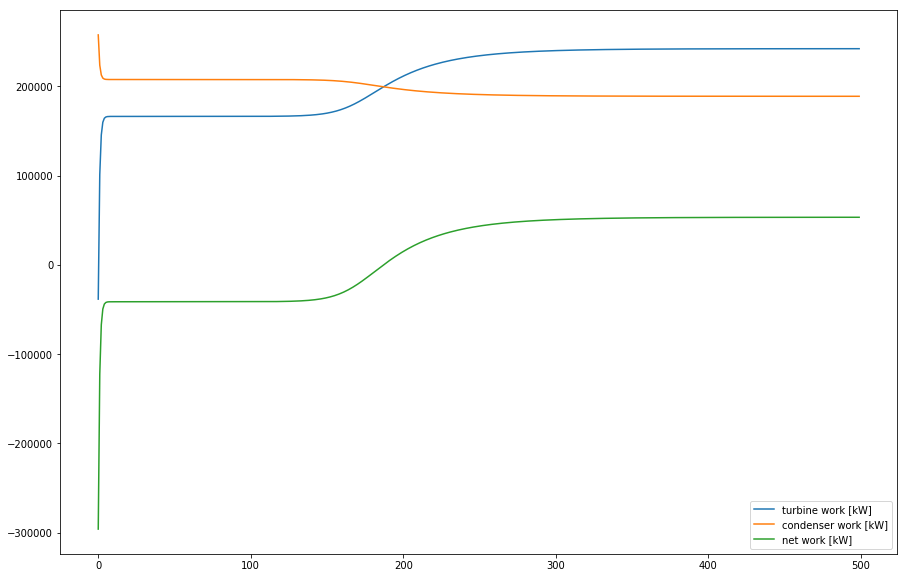

In [26]:
# plot the BOP work done
work_data = quantities2(u_vec_history, params, params['time_stamps'])
work_data.plot(x=None, y=None, kind='line', ax=None, subplots=False, sharex=None, sharey=False, layout=None, figsize=(15,10),
               use_index=True, title=None, grid=None, legend=True, style=None, logx=False, logy=False, loglog=False, 
               xticks=None, yticks=None, xlim=None, ylim=None, rot=None, fontsize=None, colormap=None, table=False, 
               yerr=None, xerr=None, secondary_y=False, sort_columns=False)

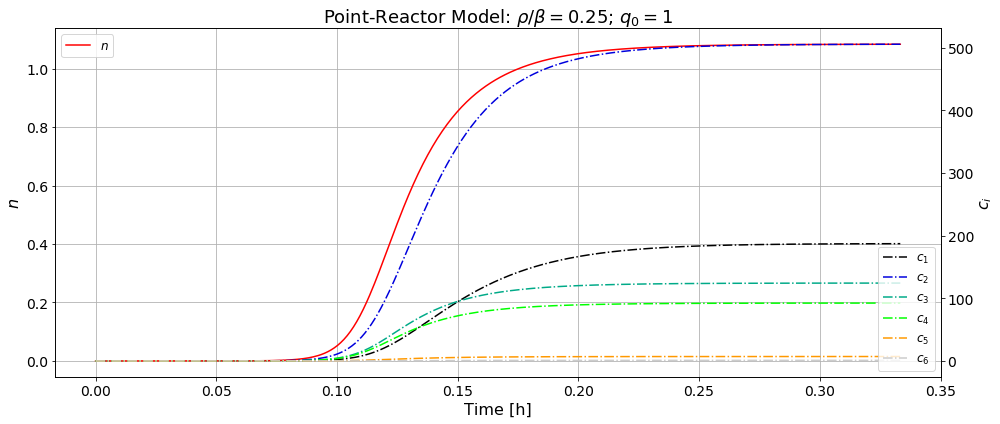

In [27]:
plot_results(u_vec_history, normalize=False)

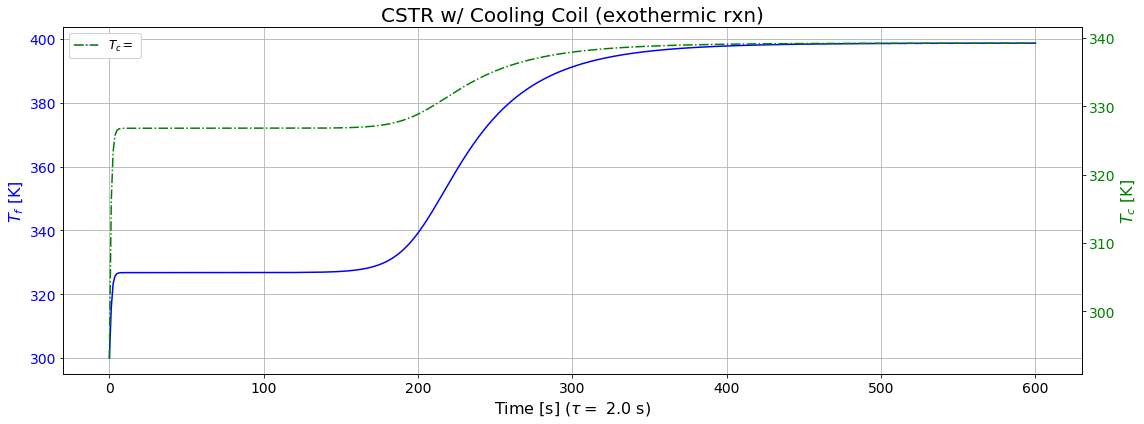

In [28]:
tmp()

# Reactor Startup and Steady State w/ condenser malfunction

In [31]:
'''Setup up initial conditions'''

import numpy as np

params['malfunction start'] = 1300 # malfunction starts at 1300 seconds and ends at 2000 seconds
params['malfunction end'] = 2000
params['breakage start'] = 3001
params['breakage end'] = 0
params['malfunction subcooling'] = 1
params['shutdown time'] = 20000

gen_time = params['gen_time'] # retrieve neutron generation time
params['q_0'] = 1

params['n_ss'] = 0 # neutronless steady state before start up

rho_0_over_beta = 0.25 # $

beta = params['beta'] # retrieve the delayed neutron fraction
params['reactivity'] = rho_0_over_beta * beta # "rho/beta = 10 cents"

params['temp_0'] = params['temp_o']

params['tau_fake'] = 2 # s



# setup remaining initial conditions
setup_initial_conditions(params)

In [30]:
'''Evolve the point-reactor'''

time_final    = 3000# 450 # s
n_time_stamps = 1000 # number of solution values in time

params['time_final']    = time_final
params['n_time_stamps'] = n_time_stamps

# Run the reactor and compute the history of the state variables; tabular form, one row per time stamp
u_vec_history = run_point_reactor( f_vec, params )
#print(u_vec_history)
print("done")

ValueError: math domain error

In [ ]:
#plot the q3prime and heat removed data
heat_data = quantities1(u_vec_history, params, params['time_stamps'])
heat_data.plot(x=None, y=None, kind='line', ax=None, subplots=False, sharex=None, sharey=False, layout=None, figsize=(15,10),
               use_index=True, title=None, grid=None, legend=True, style=None, logx=False, logy=False, loglog=False, 
               xticks=None, yticks=None, xlim=None, ylim=None, rot=None, fontsize=None, colormap=None, table=False, 
               yerr=None, xerr=None, secondary_y=False, sort_columns=False)


In [ ]:
# plot the BOP work done
work_data = quantities2(u_vec_history, params, params['time_stamps'])
work_data.plot(x=None, y=None, kind='line', ax=None, subplots=False, sharex=None, sharey=False, layout=None, figsize=(15,10),
               use_index=True, title=None, grid=None, legend=True, style=None, logx=False, logy=False, loglog=False, 
               xticks=None, yticks=None, xlim=None, ylim=None, rot=None, fontsize=None, colormap=None, table=False, 
               yerr=None, xerr=None, secondary_y=False, sort_columns=False)

In [ ]:
tmp()

In [ ]:
plot_results(u_vec_history, normalize=False)

# Complete Condenser Shutdown

In [ ]:
'''Setup up initial conditions'''

import numpy as np

params['malfunction start'] = 3001 # malfunction starts at 1300 seconds and ends at 2000 seconds
params['malfunction end'] = 0
params['breakage start'] = 2000
params['breakage end'] = 2600
params['shutdown time'] = 3001

gen_time = params['gen_time'] # retrieve neutron generation time
params['q_0'] = 1

params['n_ss'] = 0 # neutronless steady state before start up

rho_0_over_beta = 0.25 # $

beta = params['beta'] # retrieve the delayed neutron fraction
params['reactivity'] = rho_0_over_beta * beta # "rho/beta = 10 cents"

params['temp_0'] = params['temp_o']

params['tau_fake'] = 2 # s


# setup remaining initial conditions
setup_initial_conditions(params)

In [ ]:
'''Evolve the point-reactor'''

time_final    = 3000# 450 # s
n_time_stamps = 1000 # number of solution values in time

params['time_final']    = time_final
params['n_time_stamps'] = n_time_stamps

# Run the reactor and compute the history of the state variables; tabular form, one row per time stamp
u_vec_history = run_point_reactor( f_vec, params )
#print(u_vec_history)
print("done")

In [ ]:
#plot the q3prime and heat removed data
heat_data = quantities1(u_vec_history, params, params['time_stamps'])
heat_data.plot(x=None, y=None, kind='line', ax=None, subplots=False, sharex=None, sharey=False, layout=None, figsize=(15,10),
               use_index=True, title=None, grid=None, legend=True, style=None, logx=False, logy=False, loglog=False, 
               xticks=None, yticks=None, xlim=None, ylim=None, rot=None, fontsize=None, colormap=None, table=False, 
               yerr=None, xerr=None, secondary_y=False, sort_columns=False)


In [ ]:
# plot the BOP work done
work_data = quantities2(u_vec_history, params, params['time_stamps'])
work_data.plot(x=None, y=None, kind='line', ax=None, subplots=False, sharex=None, sharey=False, layout=None, figsize=(15,10),
               use_index=True, title=None, grid=None, legend=True, style=None, logx=False, logy=False, loglog=False, 
               xticks=None, yticks=None, xlim=None, ylim=None, rot=None, fontsize=None, colormap=None, table=False, 
               yerr=None, xerr=None, secondary_y=False, sort_columns=False)

In [ ]:
tmp()

In [ ]:
plot_results(u_vec_history, normalize=False)

# Shutdown

In [ ]:
'''Setup up initial conditions'''

import numpy as np

params['malfunction start'] = 13000 # malfunction starts at 1300 seconds and ends at 2000 seconds
params['malfunction end'] = 0
params['breakage start'] = 13000
params['breakage end'] = 0
params['shutdown time'] = 2000

gen_time = params['gen_time'] # retrieve neutron generation time
params['q_0'] = 1

params['n_ss'] = 0 # neutronless steady state before start up

rho_0_over_beta = 0.25 # $

beta = params['beta'] # retrieve the delayed neutron fraction
params['reactivity'] = rho_0_over_beta * beta # "rho/beta = 10 cents"

params['temp_0'] = params['temp_o']

params['tau_fake'] = 2 # s


# setup remaining initial conditions
setup_initial_conditions(params)

In [ ]:
'''Evolve the point-reactor'''

time_final    = 12000 # 450 # s
n_time_stamps = 1000 # number of solution values in time

params['time_final']    = time_final
params['n_time_stamps'] = n_time_stamps

# Run the reactor and compute the history of the state variables; tabular form, one row per time stamp
u_vec_history = run_point_reactor( f_vec, params )
#print(u_vec_history)
print("done")

In [ ]:
#plot the q3prime and heat removed data
heat_data = quantities1(u_vec_history, params, params['time_stamps'])
heat_data.plot(x=None, y=None, kind='line', ax=None, subplots=False, sharex=None, sharey=False, layout=None, figsize=(15,10),
               use_index=True, title=None, grid=None, legend=True, style=None, logx=False, logy=False, loglog=False, 
               xticks=None, yticks=None, xlim=None, ylim=None, rot=None, fontsize=None, colormap=None, table=False, 
               yerr=None, xerr=None, secondary_y=False, sort_columns=False)

In [ ]:
# plot the BOP work done
work_data = quantities2(u_vec_history, params, params['time_stamps'])
work_data.plot(x=None, y=None, kind='line', ax=None, subplots=False, sharex=None, sharey=False, layout=None, figsize=(15,10),
               use_index=True, title=None, grid=None, legend=True, style=None, logx=False, logy=False, loglog=False, 
               xticks=None, yticks=None, xlim=None, ylim=None, rot=None, fontsize=None, colormap=None, table=False, 
               yerr=None, xerr=None, secondary_y=False, sort_columns=False)

In [ ]:
tmp()

In [ ]:
plot_results(u_vec_history, normalize=False)